In [25]:

import os
import cv2
import pandas as pd
import albumentations as A
from tqdm import tqdm
import random

def generate_augmented_images(df_resampled, original_dir, output_dir, augmentations_per_image=1):
    os.makedirs(output_dir, exist_ok=True)
    
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.CLAHE(p=0.3),
    ])

    # Pre-compute existing original images to avoid repeated os.path.exists calls
    original_images = set()
    for label in os.listdir(original_dir):
        label_dir = os.path.join(original_dir, label)
        if os.path.isdir(label_dir):
            original_images.update(
                os.path.join(label, f) 
                for f in os.listdir(label_dir) 
                if f.endswith('.jpg')
            )

    generated_count = 0

    for _, row in tqdm(df_resampled.iterrows(), total=len(df_resampled)):
        original_path = os.path.join(row['label'], row['image_id'])
        output_path = os.path.join(output_dir, row['label'], row['image_id'])
        
        # Skip ONLY if the image already exists in the ORIGINAL folder
        if original_path in original_images:
            continue
            
        # Create output subdirectory if needed
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Randomly select an original image from the same class
        class_dir = os.path.join(original_dir, row['label'])
        class_images = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
        if not class_images:
            continue
            
        original_img = cv2.imread(os.path.join(class_dir, random.choice(class_images)))
        
        # Generate augmented image
        augmented = aug(image=original_img)['image']
        cv2.imwrite(output_path, augmented)
        generated_count += 1

    print(f"Generated {generated_count} synthetic images in {output_dir}")



In [26]:
df_resampled = pd.read_csv("processed_data/cleaned_metadata.csv") 
generate_augmented_images(
    df_resampled,
    original_dir="Dataset/train_images",
    output_dir="Dataset/SMOT_images"
)

  0%|          | 0/17420 [00:00<?, ?it/s]

100%|██████████| 17420/17420 [00:20<00:00, 854.84it/s] 

Generated 6125 synthetic images in Dataset/SMOT_images


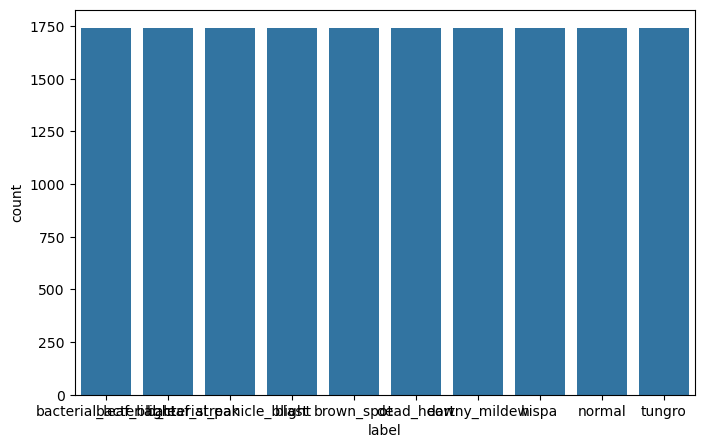

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

df_read = pd.read_csv("processed_data/cleaned_metadata.csv")
df_original = df_read.copy()
FIGSIZE = (8, 5)
plt.figure(figsize=FIGSIZE)
sns.countplot(data=df_original, x="label")
plt.show()

In [28]:
from collections import defaultdict

def count_images_in_folders(data_dir):
    """
    Counts image files in each subfolder (by label).
    
    Args:
        data_dir (str): Path to the dataset root (e.g., 'Dataset/train_images').
    
    Returns:
        dict: {label: image_count}
    """
    counts = defaultdict(int)
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            counts[label] = len([
                f for f in os.listdir(label_dir) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
    
    return dict(counts)

data_path = "Dataset/SMOT_images"  
folder_counts = count_images_in_folders(data_path)

print("=== Image Counts by Label (From Folders) ===")
for label, count in folder_counts.items():
    print(f"{label}: {count} images")
print(f"TOTAL: {sum(folder_counts.values())} images")

=== Image Counts by Label (From Folders) ===
bacterial_leaf_blight: 1004 images
bacterial_leaf_streak: 1075 images
bacterial_panicle_blight: 1114 images
blast: 24 images
brown_spot: 584 images
dead_heart: 225 images
downy_mildew: 887 images
hispa: 126 images
tungro: 487 images
TOTAL: 5526 images


In [29]:
data_path = "Dataset/train_images"  
folder_counts = count_images_in_folders(data_path)

print("=== Image Counts by Label (From Folders) ===")
for label, count in folder_counts.items():
    print(f"{label}: {count} images")
print(f"TOTAL: {sum(folder_counts.values())} images")

=== Image Counts by Label (From Folders) ===
bacterial_leaf_blight: 479 images
bacterial_leaf_streak: 380 images
bacterial_panicle_blight: 337 images
blast: 1738 images
brown_spot: 965 images
dead_heart: 1442 images
downy_mildew: 620 images
hispa: 1594 images
normal: 1764 images
tungro: 1088 images
TOTAL: 10407 images


In [30]:
import os
import shutil
from tqdm import tqdm

def merge_datasets(original_dir, smote_dir, output_dir):
    """
    Merges original and SMOTE-augmented images into a single dataset.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate through all class subdirectories
    for label in tqdm(os.listdir(original_dir)):
        original_label_dir = os.path.join(original_dir, label)
        smote_label_dir = os.path.join(smote_dir, label)
        output_label_dir = os.path.join(output_dir, label)
        
        os.makedirs(output_label_dir, exist_ok=True)
        
        for img_file in os.listdir(original_label_dir):
            src = os.path.join(original_label_dir, img_file)
            dst = os.path.join(output_label_dir, img_file)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)
        
        if os.path.exists(smote_label_dir):
            for img_file in os.listdir(smote_label_dir):
                src = os.path.join(smote_label_dir, img_file)
                dst = os.path.join(output_label_dir, img_file)
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)

    print(f"Merged dataset created at: {output_dir}")

# Usage
merge_datasets(
    original_dir="Dataset/train_images",      # Original images
    smote_dir="Dataset/SMOT_images",         # SMOTE-augmented images
    output_dir="Dataset/merged_SMOT_train"  # Final merged dataset
)

100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

Merged dataset created at: Dataset/merged_SMOT_train


In [31]:
data_path = "Dataset/merged_SMOT_train"  
folder_counts = count_images_in_folders(data_path)

print("=== Image Counts by Label (From Folders) ===")
for label, count in folder_counts.items():
    print(f"{label}: {count} images")
print(f"TOTAL: {sum(folder_counts.values())} images")

=== Image Counts by Label (From Folders) ===
bacterial_leaf_blight: 1483 images
bacterial_leaf_streak: 1455 images
bacterial_panicle_blight: 1451 images
blast: 1762 images
brown_spot: 1549 images
dead_heart: 1667 images
downy_mildew: 1507 images
hispa: 1720 images
normal: 1764 images
tungro: 1575 images
TOTAL: 15933 images
